In [9]:
import matplotlib.pyplot as plt
from matplotlib import tri
import matplotlib.tri as mtri
import numpy as np
import meshio
import imageio

In [10]:
# Dados do problemas
rho = 1.0
ni = 1.0
dt = 0.01
vx_ini = 1.0
vy_ini = 0.0
nIter = 10

In [11]:
# leitura da malha no GMSH
msh = meshio.read('../malhas/retangle.msh') 
X = msh.points[:,0]
Y = msh.points[:,1]
IEN = msh.cells[1].data
IENbound = msh.cells[0].data
IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1) 
boundNames = list(msh.field_data.keys())
IENboundElem = [boundNames[elem] for elem in IENboundTypeElem] 
npoints = len(X)
ne = IEN.shape[0]           # número de nós (vértices) - Usado para a pressão
nv = npoints + ne           # número de nós (vértices + centróides) - Usado para velocidade

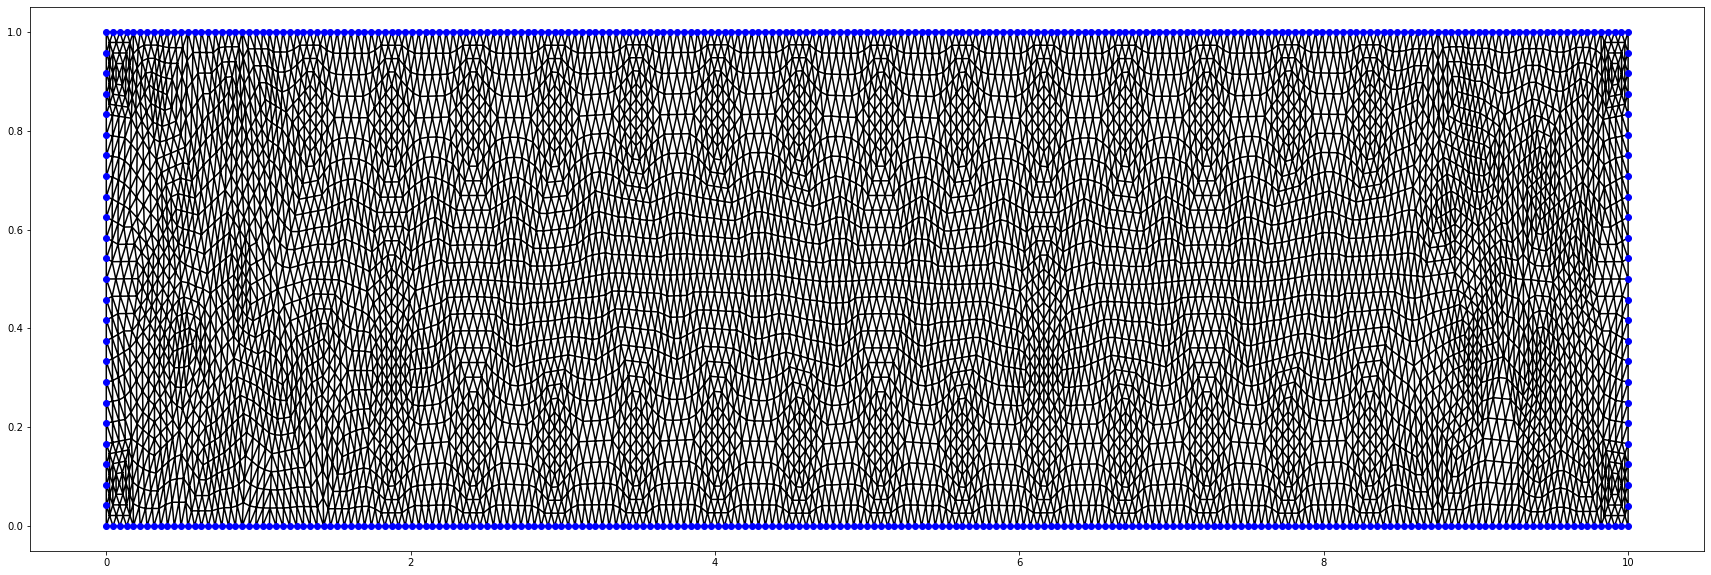

In [12]:
# cria lista de nos do contorno
cc = np.unique(IENbound.reshape(IENbound.size)) 
ccName = [[] for i in range( len(X) )]
for elem in range(0,len(IENbound)):
 ccName[ IENbound[elem][0] ] = IENboundElem[elem] 
 ccName[ IENbound[elem][1] ] = IENboundElem[elem]

#--------------------------------------------------
# plot malha e pontos de contorno 
plt.figure(figsize=(30, 10))
plt.triplot(X,Y,IEN,'k-') 
plt.plot(X[cc],Y[cc],'bo') 
plt.show()
#-------------------------------------------------- 

In [13]:
# Centróide
X_mini = X.copy()
Y_mini = Y.copy()
X_mini.resize(nv,refcheck=False)
Y_mini.resize(nv,refcheck=False)
IEN_v = np.hstack((IEN, np.zeros((ne, 1), dtype=IEN.dtype)))
print(IEN_v)

[[ 207 1937 1939    0]
 [1937 1938 1939    0]
 [1937  826 1938    0]
 ...
 [6504 5128 6418    0]
 [6504 1667 5128    0]
 [6418 5128  825    0]]


In [14]:
# Definir matrizes K, M e G, velocidade e pressão.
vx = np.zeros( (nv), dtype='float')
vy = np.zeros( (nv), dtype='float')
p = np.zeros( (npoints), dtype='float')

K = np.zeros( (nv,nv), dtype='float')
M = np.zeros( (nv,nv), dtype='float')
Gx = np.zeros( (nv, npoints), dtype='float')
Gy = np.zeros( (nv, npoints), dtype='float')
Dx = np.zeros( (npoints, nv), dtype='float')
Dy = np.ones( (npoints, nv), dtype='float')

In [15]:
# Fazer loop para calcular matrizes K, M e G.
for i in range(0, ne):
    # pega os pontos conforme a posição que aparecem na IEN
    [v1,v2,v3,v4] = IEN_v[i]
    # O valor de X e Y está na posição do ponto retirado da IEN
    Xv1 = X_mini[v1]
    Xv2 = X_mini[v2]
    Xv3 = X_mini[v3]
    Yv1 = Y_mini[v1]
    Yv2 = Y_mini[v2]
    Yv3 = Y_mini[v3]
    # Calcula o valor em x e y do centróide
    Xc = (Xv1 + Xv2 + Xv3)/3.0
    Yc = (Yv1 + Yv2 + Yv3)/3.0
    X_mini[npoints + i] = Xc
    Y_mini[npoints + i] = Yc
    # Adiciona o ponto centróide na posição correta da IEN
    IEN_v[i,3] = npoints + i    

    # calcular área do triângulo (a, b, c) e peso z para usar nas matrizes K, M, e G
    a1 = Xv2*Yv3 - Xv3*Yv2
    a2 = Xv3*Yv1 - Xv1*Yv3
    a3 = Xv1*Yv2 - Xv2*Yv1

    b1 = Yv2 - Yv3
    b2 = Yv3 - Yv1
    b3 = Yv1 - Yv2
    
    c1 = Xv3 - Xv2
    c2 = Xv1 - Xv3
    c3 = Xv2 - Xv1

    area = (1.0/2.0)*np.linalg.det( [[1,X_mini[v1],Y_mini[v1]],
                                  [1,X_mini[v2],Y_mini[v2]],
                                  [1,X_mini[v3],Y_mini[v3]] ] )
    # matriz de massa
    melem = (area/840)*np.array([[83, 13, 13, 45],
                                [13, 83, 13, 45],
                                [13, 13, 83, 45],
                                [45, 45, 45, 243]])

    # matriz de rigidez (laplaciano) e matriz dos coeficientes do laplaciano
    B = (1.0/(2.0*area))*np.array([[b1, b2, b3],
                                    [c1, c2, c3]])
    
    BT = B.transpose()

    # peso para ajustar as matrizes mini
    z = (1/(4*area))*(b2**2 + b2*b3 + b3**2 + c2**2 + c2*c3 + c3**2)
    k = area*(BT@B)

    # definição das matrizes mini em função das matrizes lineares
    # matriz k
    kelem_lin = area*(BT@B) + (9.0/10.0)*z
    k_mini = kelem_lin
    k_mini = np.hstack( (k_mini, (-27.0*z/10.0)*np.ones((k_mini.shape[0], 1), dtype=k_mini.dtype)))
    k_mini = np.vstack( (k_mini, (-27.0*z/10.0)*np.ones((k_mini.shape[1]), dtype=k_mini.dtype)))
    k_mini[-1,-1] = 81.0*z/10.0

    # matrizes gx e gy
    gx_elem_lin = (1.0/6.0)* np.array([[b1,b2,b3],
                                    [b1,b2,b3],
                                    [b1,b2,b3]])
    gx_elem_linT = gx_elem_lin.transpose()
    gx_mini = (9.0/20.0)*gx_elem_lin + gx_elem_linT
    gx_mini = np.vstack( (gx_mini, (-9.0/40.0)*np.array([b1, b2, b3])*np.ones((gx_mini.shape[1]), dtype=gx_mini.dtype)))

    gy_elem_lin = (1.0/6.0)* np.array([[c1,c2,c3],
                                    [c1,c2,c3],
                                    [c1,c2,c3]])
    gy_elem_linT = gy_elem_lin.transpose()
    gy_mini = (9.0/20.0)*gy_elem_lin + gy_elem_linT
    gy_mini = np.vstack( (gy_mini, (-9.0/40.0)*np.array([c1, c2, c3])*np.ones((gy_mini.shape[1]), dtype=gy_mini.dtype)))

    for ilocal in range(0,4):
        iglobal = IEN_v[i, ilocal]
        for jlocal in range(0,4):
            jglobal = IEN_v[i, jlocal]

            K[iglobal, jglobal] += k_mini[ilocal, jlocal]
            M[iglobal, jglobal] += melem[ilocal, jlocal]

        for jlocal in range(0,3):
            jglobal = IEN[i, jlocal]

            Gx[iglobal, jglobal] += gx_mini[ilocal, jlocal]
            Gy[iglobal, jglobal] += gy_mini[ilocal, jlocal]


# Gerar as matrizes Dx e Dy (transpor matrizes Gx e Gy)
Dx = Gx.transpose()
Dy = Gy.transpose()

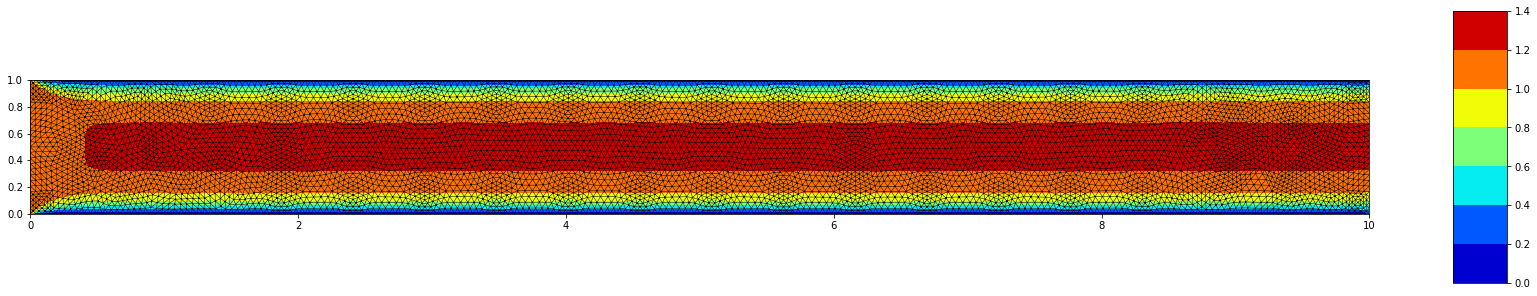

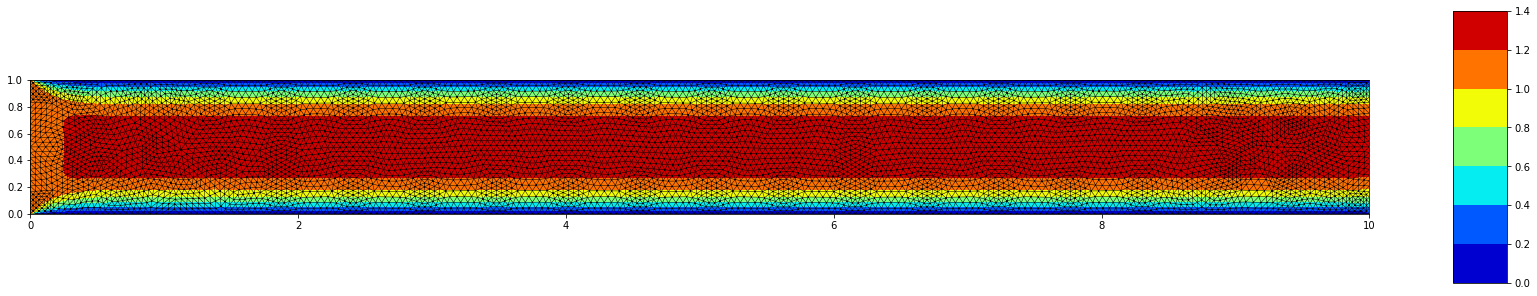

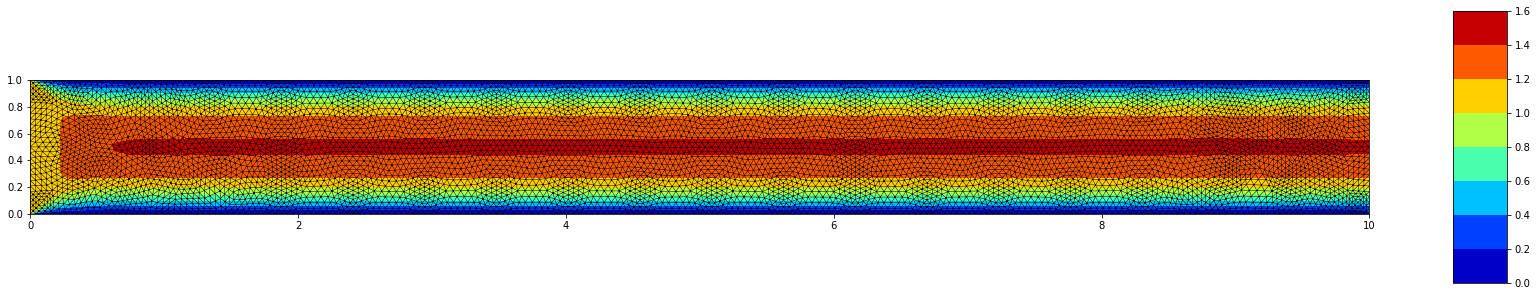

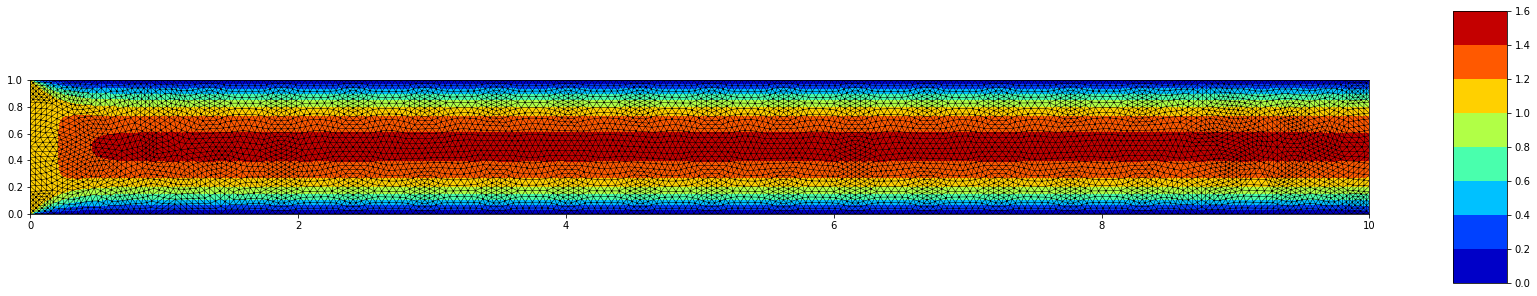

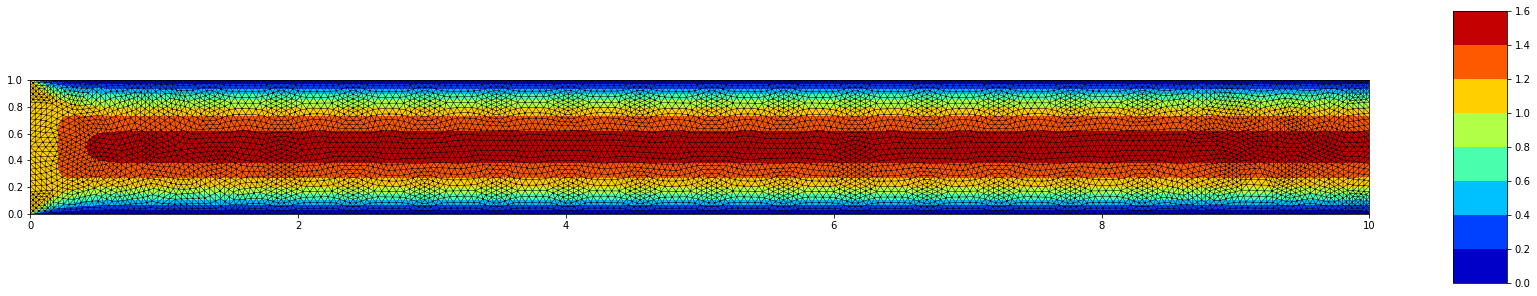

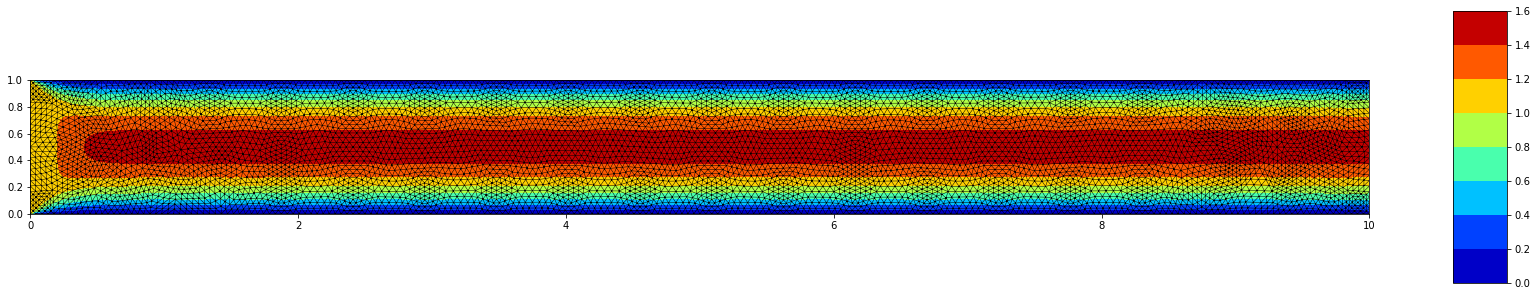

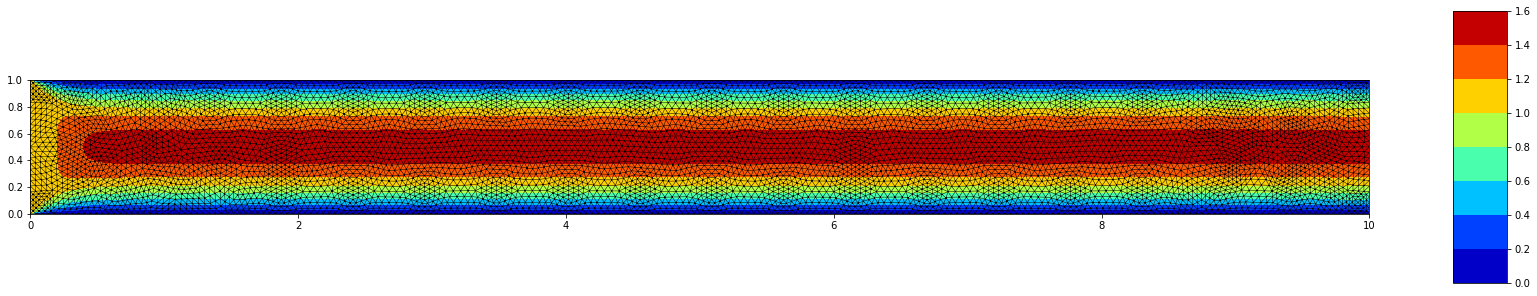

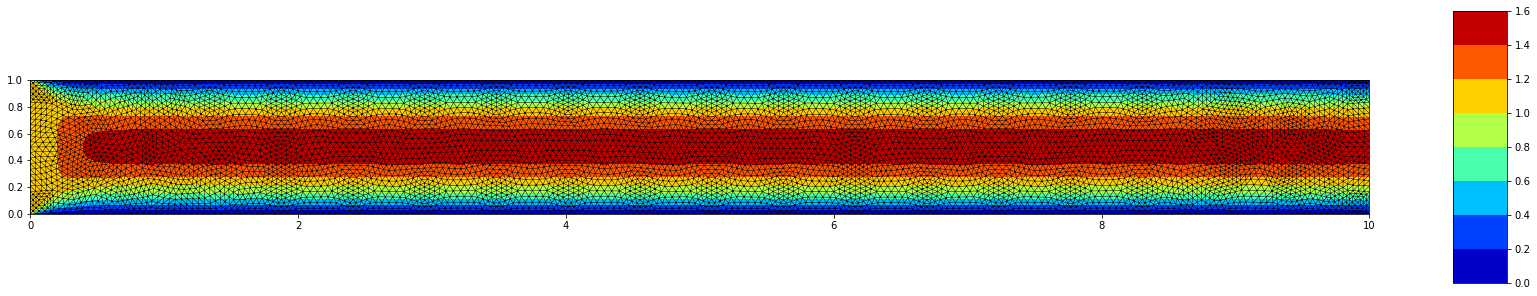

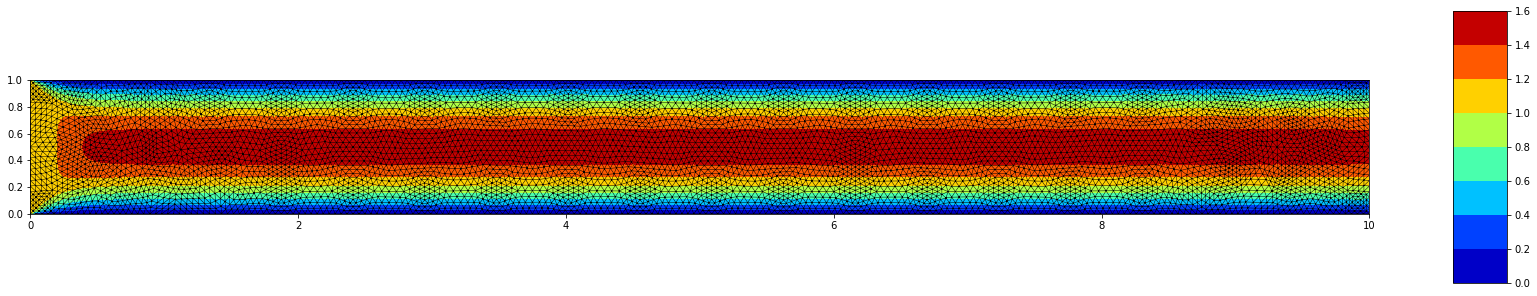

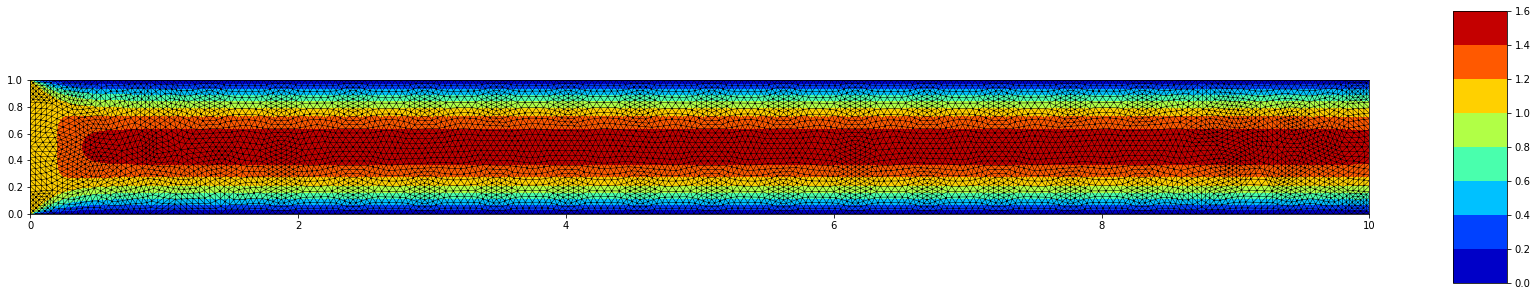

In [16]:
A_vx = np.hstack(((M/dt+ni*K),np.zeros((K.shape), dtype=K.dtype), (-1/rho)*Gx))
A_vy = np.hstack((np.zeros((K.shape),dtype=K.dtype),(M/dt+ni*K), (-1/rho)*Gy))
A_p = np.hstack((Dx, Dy, np.zeros((npoints,npoints), dtype=K.dtype)))
A = np.vstack((A_vx, A_vy, A_p))

for i in cc:
    if ccName[i] == 'inlet':
        A[i,:] = 0.0                    # zera as linhas referentes a vx
        A[i,i] = 1.0                    # coloca 1 na diagonal referente a vx
        A[i+nv,:] = 0.0                 # zera as linhas referentes a vy
        A[i+nv, i+nv] = 1.0             # coloca 1 na diagonal referente a vy

    if ccName[i] == 'outlet':
        A[i+2*nv,:] = 0.0               # zera as linhas referentes a p
        A[i+2*nv, i+2*nv] = 1.0         # coloca 1 na diagonal referente a p

    if ccName[i] == 'paredeInf':
        A[i,:] = 0.0                    # zera as linhas referentes a vx
        A[i,i] = 1.0                    # coloca 1 na diagonal referente a vx
        A[i+nv, :] = 0.0                # zera as linhas referentes a vy
        A[i+nv, i+nv] = 1.0             # coloca 1 na diagonal referente a vy

    if ccName[i] == 'paredeSup':
        A[i,:] = 0.0                    # zera as linhas referentes a vx
        A[i,i] = 1.0                    # coloca 1 na diagonal referente a vx
        A[i+nv, :] = 0.0                # zera as linhas referentes a vy
        A[i+nv, i+nv] = 1.0             # coloca 1 na diagonal referente a vy

sol = np.zeros((2*nv+npoints))
b = np.hstack((vx, vy, p))

figlist = []
for n in range(0,nIter):
    Vx = sol[0:nv]
    Vy = sol[nv: 2*nv]
    b[0::] = 0.0
    b[0:nv] = (M/dt)@Vx
    b[nv:2*nv] = (M/dt)@Vy

    # definir condições de contorno para b
    for i in cc:
        if ccName[i] == 'inlet':
            b[i] = 1.0                      # velocidade em vx na CC
            b[i+nv] = 0.0                   # velocidade em vy na CC

        if ccName[i] == 'outlet':
            b[i+2*nv] = 0.0                 # pressão na CC

        if ccName[i] == 'paredeInf':
            b[i] = 0.0                      # velocidade em vx na CC
            b[i+nv] = 0.0                   # velocidade em vy na CC

        if ccName[i] == 'paredeSup':
            b[i] = 0.0                      # velocidade em vx na CC
            b[i+nv] = 0.0                   # velocidade em vy na CC

    sol = np.linalg.solve(A,b)
    # plot dos resultados
    triang = mtri.Triangulation(X_mini,Y_mini,IEN)
    plt.figure(figsize=(30, 10))
    ax = plt.axes()
    ax.set_aspect('equal')
    surf = ax.tricontourf(triang,sol[0:nv],cmap='jet')
    plt.colorbar(surf,shrink=0.5, aspect=5)
    plt.triplot(X,Y,IEN,'k-', markersize=0.1, linewidth=0.5)
    figname = 'figs/Retangle_'+str(n)
    plt.savefig(figname)
    figlist.append(figname)
    plt.show()
    


In [17]:
# Build GIF
with imageio.get_writer('retangle.gif', mode='I') as writer:
    for filename in figlist:
        image = imageio.imread(filename+'.png')
        writer.append_data(image)

: 